# Visual Wake Word Example



### Import Necessary Libraries

This cell imports essential libraries: Gradio for the interface, OpenCV for image processing, the Akida library for model execution, and NumPy and Plotly for data handling and visualization.

In [1]:
import gradio as gr
import cv2

from cnn2snn import set_akida_version, AkidaVersion
import akida

import numpy as np

import time

import plotly.graph_objects as go

/home/guest/.conda/envs/akida_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-31 14:45:37.554567: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 14:45:37.575472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 14:45:37.575489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 14:45:

### Gauge Creation Function

Defines a function using Plotly to create a gauge visualization for metrics such as frames per second during image classification.

In [2]:
def create_gauge(value):
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=value,
        gauge={'axis': {'range': [0, 30]}},
        domain={'x': [0, 1], 'y': [0, 1]},
    ))
    fig.update_layout(width=400, height=300)
    return fig

### Softmax Function for Arrays

Implements a softmax function to convert model outputs into probability distributions.

In [3]:
# Softmax for an array of values
def softmaxArray(values):
    # Assuming array shape is (1, 1, 1, x), flatten to get the values
    values = values.ravel()
    exp_values = np.exp(values)
    sum_exp = np.sum(exp_values)
    softmax_values = exp_values / sum_exp
    return softmax_values

### Image Configuration and Output Decoding

Sets up image parameters and label names, and includes a function to preprocess images and decode predictions into readable labels.

In [4]:
image_x = 96
image_y = 96
image_z = 3
labels = ["no person", "person"]
def decodeOutput(inp):
        global akida_model
        inp = cv2.resize(inp, (image_x, image_y))
        inp = inp.reshape((-1, image_x, image_y, image_z))
        timer_start = time.time()
        predictions = softmaxArray(akida_model.predict(inp))
        frame_time = time.time() - timer_start
        fps = 1 / frame_time if frame_time > 0 else 0
        confidences = {labels[i]: predictions[i] for i in range(len(predictions))}

        return confidences, fps

### Image Classification Wrapper

A function that processes an image, decodes it, and returns classification confidences with a gauge visualization of processing speed.

In [5]:
def classify_image(inp):

  confidences, fps = decodeOutput(inp)

  return confidences, create_gauge(round(fps, 2))

### Load Pre-trained Model

Loads a pre-trained quantized model for visual wake word detection via `akida_models`.

In [6]:
from akida_models.model_io import load_model
akida_model = load_model("models/akidanet_vww_i8_w4_a4.fbz")
akida_model.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[96, 96, 3]  [1, 1, 2]     1          26    
______________________________________________

___________________________________________________________________
Layer (type)                       Output shape  Kernel shape    

================= SW/conv_0-dequantizer (Software) ================

conv_0 (InputConv2D)               [48, 48, 8]   (3, 3, 3, 8)    
___________________________________________________________________
conv_1 (Conv2D)                    [48, 48, 16]  (3, 3, 8, 16)   
___________________________________________________________________
conv_2 (Conv2D)                    [24, 24, 32]  (3, 3, 16, 32)  
___________________________________________________________________
conv_3 (Conv2D)                    [24, 24, 32]  (3, 3, 32, 32)  
___________________________________________________________________
dw_separable_4 (DepthwiseCon

Map the `akida_model` onto the device.

In [7]:
with set_akida_version(AkidaVersion.v2):
            devices = akida.devices()
            if len(devices) > 0:
                print(f'Available devices: {[dev.desc for dev in devices]}')
                device = devices[0]
                print(device.version)
                try:
                    akida_model.map(device)
                    print(f"Mapping to Akida device {device.desc}.")
                    mappedDevice = device.version
                except Exception as e:
                    print("Model not compatible with FPGA. Running on CPU.")
                    mappedDevice = "CPU"
            else:
                print("No Akida devices found, running on CPU.")
                mappedDevice = "CPU"

Available devices: ['fpga-1691']
BC.A2.001.000
Mapping to Akida device fpga-1691.


### Model Summary After Mapping

In [8]:
akida_model.summary()

                                     Model Summary                                     
_______________________________________________________________________________________
Input shape  Output shape  Sequences  Layers  NPs  Skip DMAs  External Memory (Bytes)
[96, 96, 3]  [1, 1, 2]     1          26      24   0          528                    
_______________________________________________________________________________________

_________________________
Component (type)  Count
HRC               1    
_________________________
CNP1              23   
_________________________
FNP2              1    
_________________________

            External Memory Summary            
_______________________________________________
Layer (type)          External Memory (Bytes)
classifier (Dense1D)  528                    
_______________________________________________

_______________________________________________________________________________
Layer (type)                       Output sha

### Gradio Interface Setup

Creates a Gradio interface to capture webcam images, display device information, and stream classified images using the Akida model. The interface shows live predictions and frame processing speeds.

In [9]:
theme = gr.themes.Base(
    text_size="sm",
    spacing_size="sm",
    radius_size="sm",
)

with gr.Blocks(
    title="Brainchip",
    fill_width=True,
    fill_height=True,
    delete_cache=[180, 600],
    theme=theme
) as demo:
    gr.Markdown("""
        <h1 style="text-align: center;">Akida Cloud</h1>
        <br>
        """)
    with gr.Row():
        gr.Markdown("## Image Classification")
    with gr.Row():
        with gr.Column():
            input_img = gr.Image(sources=["webcam"], type="numpy")
            gr.Markdown("**ℹ️ Please press the 'Record' button to start inference.**")
        with gr.Column():
            gr.Markdown(f"""Device: {mappedDevice}""")
            output_label = gr.Label(num_top_classes=3)
            print(output_label)
            plot = gr.Plot(label="Frames per second")
        dep = input_img.stream(classify_image, [input_img], [output_label, plot],
                                time_limit=30, stream_every=0.1, concurrency_limit=30)        


if __name__ == "__main__":
    demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


#### Note: Once you’ve finished running the notebook, ***"Uncomment and run the cell below"*** to release the device and free it up for further experiments.

In [10]:
# import os
# os._exit(00)

#### You can also use this button to reset your kernel

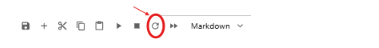